<a href="https://colab.research.google.com/github/fsamura01/machine-learning-zoomcamp/blob/main/Deep_learning_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/data.zip

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt

In [ ]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class HairClassifier(nn.Module):
    def __init__(self):
        super(HairClassifier, self).__init__()

        # Convolutional layer: 3 input channels (RGB) -> 32 output channels
        # Kernel size 3x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()

        # Max pooling: 2x2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # After conv (200->198) and pooling (198->99):
        # Feature map size: 32 channels x 99 x 99 = 313,632
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 99 * 99, 64)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

        # Note: We don't add Sigmoid here because BCEWithLogitsLoss applies it internally
        # This is more numerically stable

    def forward(self, x):
        # Input: (batch_size, 3, 200, 200)
        x = self.conv1(x)      # -> (batch_size, 32, 198, 198)
        x = self.relu1(x)      # -> (batch_size, 32, 198, 198)
        x = self.pool(x)       # -> (batch_size, 32, 99, 99)
        x = self.flatten(x)    # -> (batch_size, 313632)
        x = self.fc1(x)        # -> (batch_size, 64)
        x = self.relu2(x)      # -> (batch_size, 64)
        x = self.fc2(x)        # -> (batch_size, 1)
        return x

# Create model instance
model = HairClassifier().to(device)


In [ ]:
print("\n" + "="*70)
print("MODEL ARCHITECTURE SUMMARY")
print("="*70)
summary(model, input_size=(3, 200, 200))

# Manual parameter count
total_params = sum(p.numel() for p in model.parameters())
print(f"\nQUESTION 2 ANSWER: Total parameters = {total_params}")
print("="*70 + "\n")


MODEL ARCHITECTURE SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
              ReLU-2         [-1, 32, 198, 198]               0
         MaxPool2d-3           [-1, 32, 99, 99]               0
           Flatten-4               [-1, 313632]               0
            Linear-5                   [-1, 64]      20,072,512
              ReLU-6                   [-1, 64]               0
            Linear-7                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 23.93
Params size (MB): 76.57
Estimated Total Size (MB): 100.96
----------------------------------------------------------------

QUESTION 2 ANSWER: Total parameters = 20073473



In [ ]:
criterion = nn.BCEWithLogitsLoss()
print("QUESTION 1 ANSWER: Using nn.BCEWithLogitsLoss()")

# Optimizer with specified parameters
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.8)
print("Optimizer: SGD with lr=0.002, momentum=0.8")

QUESTION 1 ANSWER: Using nn.BCEWithLogitsLoss()
Optimizer: SGD with lr=0.002, momentum=0.8


In [ ]:
# Define transformations (without augmentation initially)
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )  # ImageNet normalization
])

test_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
# Load datasets
train_dataset = datasets.ImageFolder('data/train', transform=train_transforms)
validation_dataset = datasets.ImageFolder('data/test', transform=test_transforms)


In [ ]:
# Create data loaders
batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(validation_dataset)}")
print(f"Classes: {train_dataset.classes}\n")

Training samples: 800
Validation samples: 201
Classes: ['curly', 'straight']



In [ ]:
def train_and_evaluate_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs, device, history=None):

  # Initialize history if not provided, or continue from existing history
  if history is None:
    history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

  return history # Added: return the history dictionary

In [ ]:
print("="*70)
print("TRAINING PHASE 1: 10 Epochs WITHOUT Data Augmentation")
print("="*70)

history = train_and_evaluate_model(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    device=device,
    history=None
)

TRAINING PHASE 1: 10 Epochs WITHOUT Data Augmentation
Epoch 1/10, Loss: 0.6665, Acc: 0.6112, Val Loss: 0.6511, Val Acc: 0.6617
Epoch 2/10, Loss: 0.5702, Acc: 0.6787, Val Loss: 0.6332, Val Acc: 0.6318
Epoch 3/10, Loss: 0.5207, Acc: 0.7350, Val Loss: 0.6143, Val Acc: 0.6766
Epoch 4/10, Loss: 0.4773, Acc: 0.7600, Val Loss: 0.6049, Val Acc: 0.6617
Epoch 5/10, Loss: 0.4606, Acc: 0.7550, Val Loss: 0.7307, Val Acc: 0.5672
Epoch 6/10, Loss: 0.3954, Acc: 0.8275, Val Loss: 0.6412, Val Acc: 0.6866
Epoch 7/10, Loss: 0.2844, Acc: 0.8838, Val Loss: 0.8307, Val Acc: 0.6816
Epoch 8/10, Loss: 0.2885, Acc: 0.8788, Val Loss: 0.7052, Val Acc: 0.7114
Epoch 9/10, Loss: 0.1882, Acc: 0.9313, Val Loss: 0.9275, Val Acc: 0.6866
Epoch 10/10, Loss: 0.2585, Acc: 0.8912, Val Loss: 0.8158, Val Acc: 0.6915


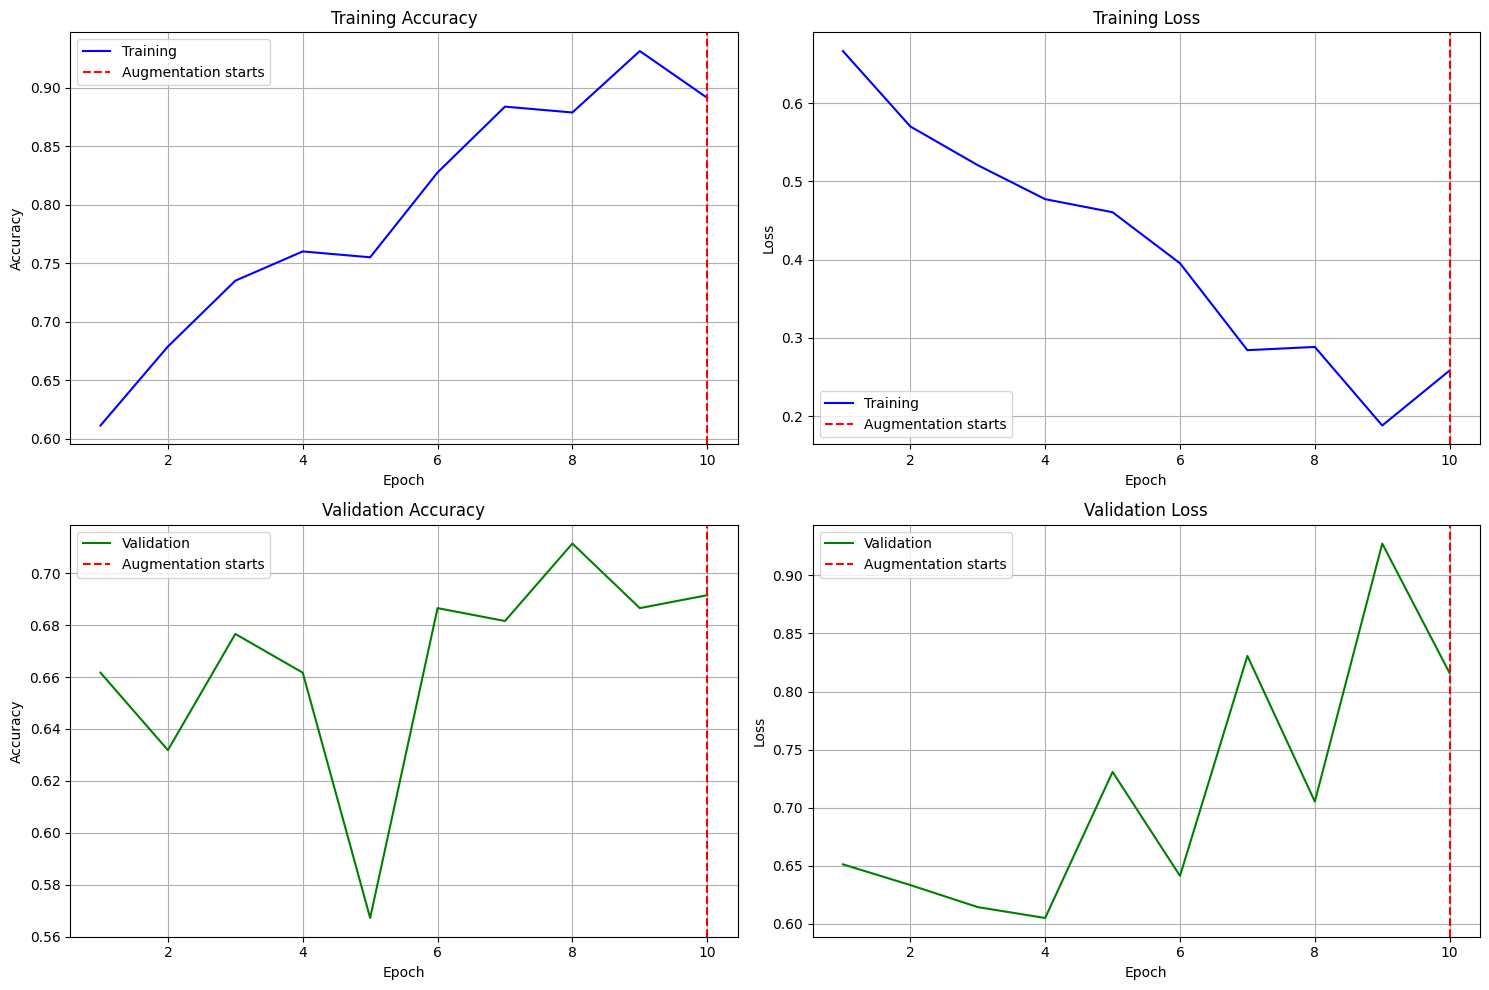

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    """Plot training history"""
    epochs_all = range(1, len(history['acc']) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Training Accuracy
    axes[0, 0].plot(epochs_all, history['acc'], 'b-', label='Training')
    axes[0, 0].axvline(x=10, color='r', linestyle='--', label='Augmentation starts')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Training Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Training Loss
    axes[0, 1].plot(epochs_all, history['loss'], 'b-', label='Training')
    axes[0, 1].axvline(x=10, color='r', linestyle='--', label='Augmentation starts')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Training Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Validation Accuracy
    axes[1, 0].plot(epochs_all, history['val_acc'], 'g-', label='Validation')
    axes[1, 0].axvline(x=10, color='r', linestyle='--', label='Augmentation starts')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Validation Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Validation Loss
    axes[1, 1].plot(epochs_all, history['val_loss'], 'g-', label='Validation')
    axes[1, 1].axvline(x=10, color='r', linestyle='--', label='Augmentation starts')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_title('Validation Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_history(history)

In [ ]:
print("\n" + "="*70)
print("RESULTS - PHASE 1 (No Augmentation)")
print("="*70)

median_of_train_acc = np.median(history['acc'])
std_of_train_loss = np.std(history['loss'])

print(f"QUESTION 3 ANSWER: Median training accuracy = {median_of_train_acc:.4f}")
print(f"QUESTION 4 ANSWER: Std of training loss = {std_of_train_loss:.4f}")
print("="*70 + "\n")


RESULTS - PHASE 1 (No Augmentation)
QUESTION 3 ANSWER: Median training accuracy = 0.7937
QUESTION 4 ANSWER: Std of training loss = 0.1462



In [ ]:
print("="*70)
print("TRAINING PHASE 2: 10 MORE Epochs WITH Data Augmentation")
print("="*70)

# Define augmented transformations
train_transforms_augmented = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

TRAINING PHASE 2: 10 MORE Epochs WITH Data Augmentation


In [ ]:
# Reload training dataset with augmentation
train_dataset_augmented = datasets.ImageFolder('data/train',
                                               transform=train_transforms_augmented)
train_loader_augmented = DataLoader(train_dataset_augmented,
                                   batch_size=batch_size,
                                   shuffle=True)

In [ ]:
history = train_and_evaluate_model(
    model=model,
    train_loader=train_loader_augmented,
    validation_loader=validation_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    device=device,
    history=history
)

Epoch 1/10, Loss: 0.6472, Acc: 0.6538, Val Loss: 0.6915, Val Acc: 0.7114
Epoch 2/10, Loss: 0.6190, Acc: 0.6475, Val Loss: 0.6385, Val Acc: 0.6368
Epoch 3/10, Loss: 0.5847, Acc: 0.6837, Val Loss: 0.6113, Val Acc: 0.6667
Epoch 4/10, Loss: 0.5550, Acc: 0.7137, Val Loss: 0.5822, Val Acc: 0.6965
Epoch 5/10, Loss: 0.5504, Acc: 0.7163, Val Loss: 0.5481, Val Acc: 0.7015
Epoch 6/10, Loss: 0.5197, Acc: 0.7312, Val Loss: 0.6437, Val Acc: 0.6667
Epoch 7/10, Loss: 0.5224, Acc: 0.7388, Val Loss: 0.5869, Val Acc: 0.6866
Epoch 8/10, Loss: 0.5288, Acc: 0.7137, Val Loss: 0.6322, Val Acc: 0.6468
Epoch 9/10, Loss: 0.5174, Acc: 0.7388, Val Loss: 0.5446, Val Acc: 0.7065
Epoch 10/10, Loss: 0.5069, Acc: 0.7638, Val Loss: 0.5622, Val Acc: 0.7214


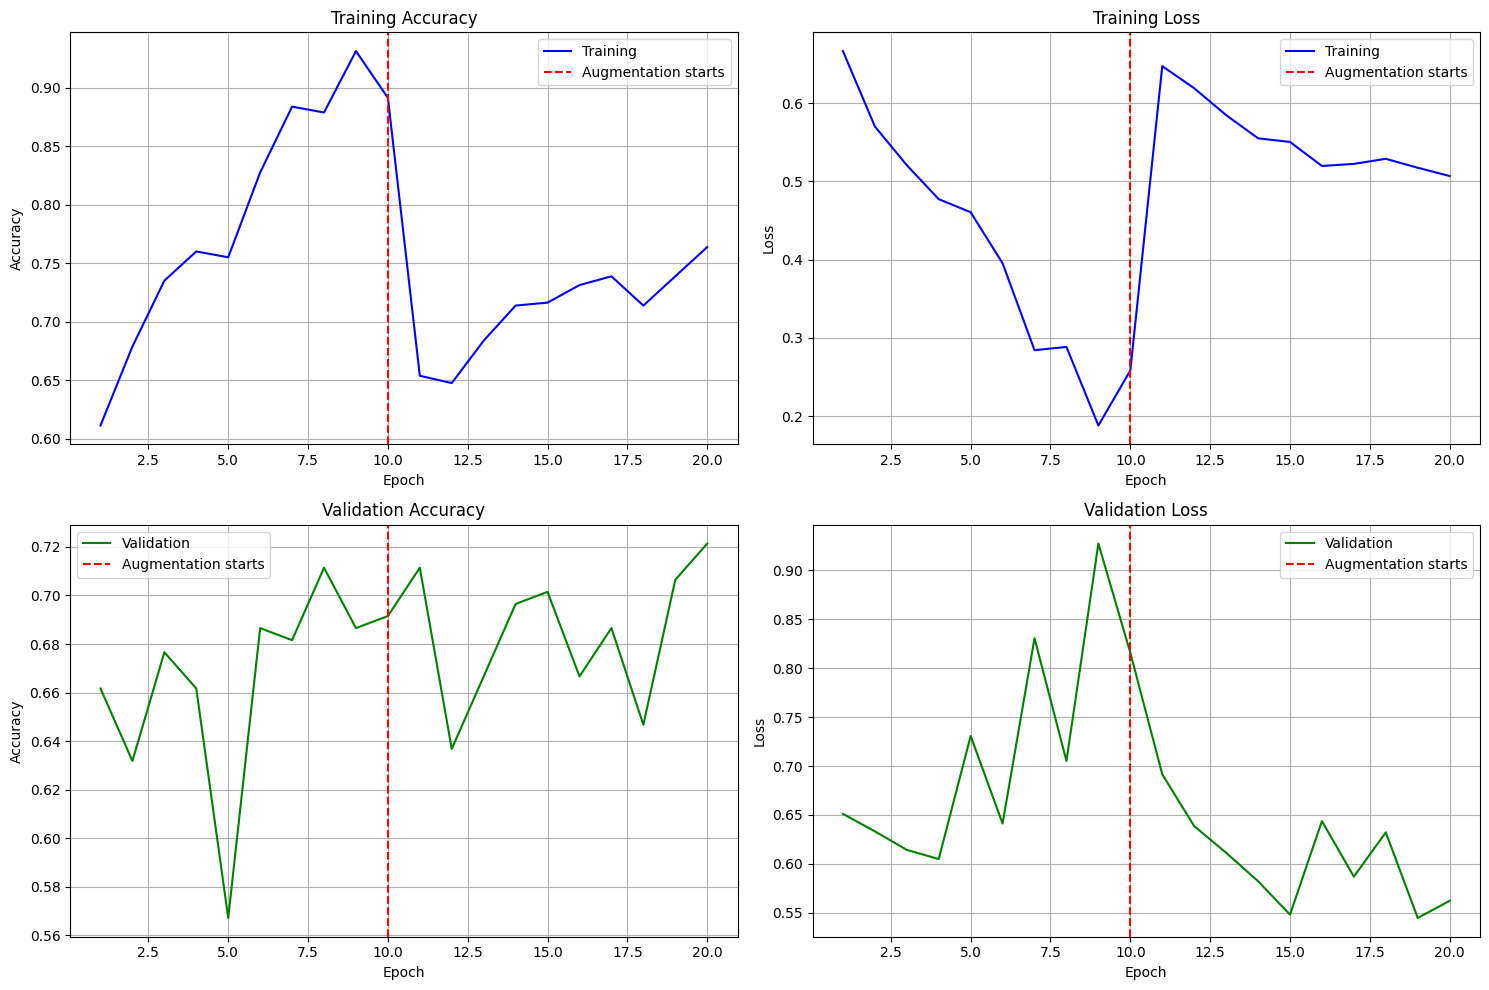

In [ ]:
plot_history(history)

In [ ]:
print("\n" + "="*70)
print("RESULTS - PHASE 2 (With Augmentation)")
print("="*70)

# Get metrics from augmented training (epochs 11-20)
augmented_val_loss = history['val_loss'][10:]  # Last 10 epochs
augmented_val_acc = history['val_acc'][10:]    # Last 10 epochs

mean_test_loss_augmented = np.mean(augmented_val_loss)
avg_test_acc_last5 = np.mean(augmented_val_acc[-5:])  # Epochs 16-20 (6-10 of augmented)

print(f"✓ QUESTION 5 ANSWER: Mean test loss (augmented) = {mean_test_loss_augmented:.4f}")
print(f"✓ QUESTION 6 ANSWER: Avg test accuracy (last 5 epochs) = {avg_test_acc_last5:.4f}")
print("="*70 + "\n")


RESULTS - PHASE 2 (With Augmentation)
✓ QUESTION 5 ANSWER: Mean test loss (augmented) = 0.6041
✓ QUESTION 6 ANSWER: Avg test accuracy (last 5 epochs) = 0.6856



In [ ]:
print("\n" + "="*70)
print("HOMEWORK ANSWERS SUMMARY")
print("="*70)
print(f"Question 1: Loss Function = nn.BCEWithLogitsLoss()")
print(f"Question 2: Total Parameters = {total_params}")
print(f"Question 3: Median Training Accuracy = {median_of_train_acc:.4f}")


print(f"Question 4: Std Training Loss = {std_of_train_loss:.4f}")
print(f"Question 5: Mean Test Loss (Augmented) = {mean_test_loss_augmented:.4f}")
print(f"Question 6: Avg Test Acc (Last 5) = {avg_test_acc_last5:.4f}")
print("="*70)


HOMEWORK ANSWERS SUMMARY
Question 1: Loss Function = nn.BCEWithLogitsLoss()
Question 2: Total Parameters = 20073473
Question 3: Median Training Accuracy = 0.7937
Question 4: Std Training Loss = 0.1462
Question 5: Mean Test Loss (Augmented) = 0.6041
Question 6: Avg Test Acc (Last 5) = 0.6856
